In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import laspy
import os

# 读取数据
data = np.loadtxt('../../data/bridge-5cls-fukushima/raw/Bridge1.txt', delimiter=' ')

# 分离护栏数据（label == 3）
parapet_data = data[data[:, 6] == 3]

# 提取x, y, z坐标
parapet_coords = parapet_data[:, :3]

print(f"Total points: {data.shape[0]}")
print(f"Parapet points: {parapet_data.shape[0]}")


Total points: 28956502
Parapet points: 300831


In [18]:
from sklearn.cluster import KMeans

# 使用K-means将护栏数据分成两组
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(parapet_coords)

parapet1 = parapet_coords[clusters == 0]
parapet2 = parapet_coords[clusters == 1]

print(f"Parapet 1 points: {parapet1.shape[0]}")
print(f"Parapet 2 points: {parapet2.shape[0]}")


Parapet 1 points: 191465
Parapet 2 points: 109366


In [19]:
def perform_pca(data):
    pca = PCA(n_components=3)
    pca.fit(data)
    return pca

pca1 = perform_pca(parapet1)
pca2 = perform_pca(parapet2)

# 计算每个护栏的长度
def calculate_length(data, pca):
    projected_data = pca.transform(data)
    length = np.max(projected_data[:, 0]) - np.min(projected_data[:, 0])
    return length

length1 = calculate_length(parapet1, pca1)
length2 = calculate_length(parapet2, pca2)
avg_length = (length1 + length2)*0.5

print(f"Estimated length of parapet 1: {length1:.2f}")
print(f"Estimated length of parapet 2: {length2:.2f}")
print(f"Estimated average length: {avg_length:.2f}")

Estimated length of parapet 1: 4.72
Estimated length of parapet 2: 5.38
Estimated average length: 5.05


In [20]:
def calculate_width(parapet1, parapet2, pca1, pca2):
    # 获取两个护栏的中心点
    center1 = np.mean(parapet1, axis=0)
    center2 = np.mean(parapet2, axis=0)
    
    # 计算中心点之间的距离
    width = np.linalg.norm(center2 - center1)
    
    return width

width = calculate_width(parapet1, parapet2, pca1, pca2)
print(f"Estimated width of the bridge: {width:.2f}")


Estimated width of the bridge: 4.41


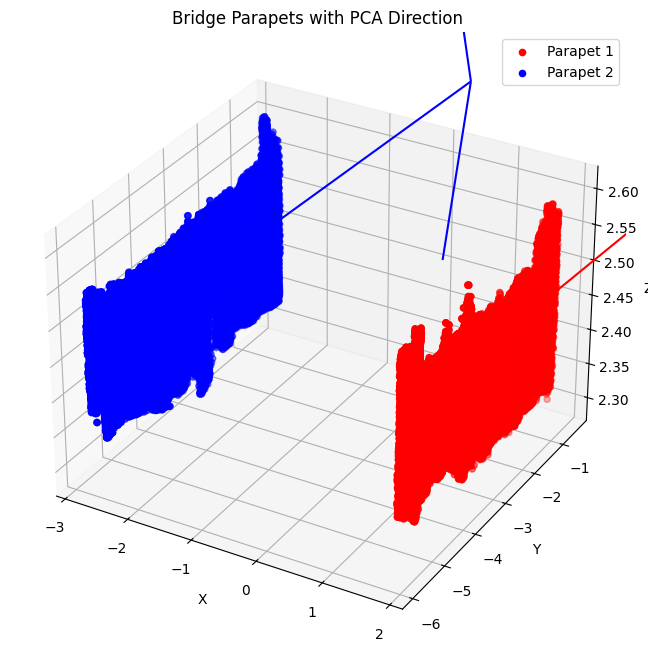

In [21]:
def plot_parapets(parapet1, parapet2, pca1, pca2):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制两个护栏的点
    ax.scatter(parapet1[:, 0], parapet1[:, 1], parapet1[:, 2], c='r', label='Parapet 1')
    ax.scatter(parapet2[:, 0], parapet2[:, 1], parapet2[:, 2], c='b', label='Parapet 2')
    
    # 绘制PCA的主方向
    for parapet, pca, color in [(parapet1, pca1, 'r'), (parapet2, pca2, 'b')]:
        center = np.mean(parapet, axis=0)
        direction = pca.components_[0]
        ax.quiver(center[0], center[1], center[2], 
                  direction[0], direction[1], direction[2], 
                  length=10, color=color, arrow_length_ratio=0.1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('Bridge Parapets with PCA Direction')
    plt.show()

plot_parapets(parapet1, parapet2, pca1, pca2)


In [22]:
import laspy
# 分离各列数据
x, y, z, r, g, b, label = data.T

r_16bit = (r * 65535).astype(np.uint16)
g_16bit = (g * 65535).astype(np.uint16)
b_16bit = (b * 65535).astype(np.uint16)

# 创建LAS文件
las = laspy.create(file_version="1.3", point_format=3)

# 设置头部信息
las.header.offsets = [np.min(x), np.min(y), np.min(z)]
las.header.scales = [0.001, 0.001, 0.001]

# 写入点数据
las.x = x
las.y = y
las.z = z
las.red = r_16bit
las.green = g_16bit
las.blue = b_16bit
las.classification  = label.astype(np.uint8)

# 保存LAS文件
las.write('output-1.las')

print("LAS文件已创建：output.las")

LAS文件已创建：output.las
